# 海洋要素计算 编程作业5


- 1. 画出波面高度时间序列，利用上跨零点或者下跨零点的方法读取数据资料中的波高、周期等波浪要素，并画图展示。  
- 2. 画出波高的概率密度分布，并计算给出有效波高和有效波周期   

数据：
- data.txt
    - 一维海浪时间序列，共2048个数据，总时间长度为512s，时间间隔0.25s，数据单位为米（m）  

**Developed By [Hanxue Yu](https://github.com/Yuhan-xue) 02\06\2023**  
**Student ID: 20010006082**

In [24]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from statsmodels.tsa.stattools import adfuller
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

mpl.rcParams['font.sans-serif'] = ['LXGW Bright']
# 字体下载 https://github.com/lxgw/LxgwBright
mpl.rcParams['axes.unicode_minus'] = False

import sys
print(sys.version)
!pip list | grep numpy
!pip list | grep pandas
!pip list | grep matplotlib
!pip list | grep scipy
!pip list | grep statsmodels
!pip list | grep seaborn

3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
numpy                          1.24.3
pandas                         1.5.3
matplotlib                     3.7.1
matplotlib-inline              0.1.6
scipy                          1.10.1
statsmodels                    0.13.5
seaborn                        0.12.2


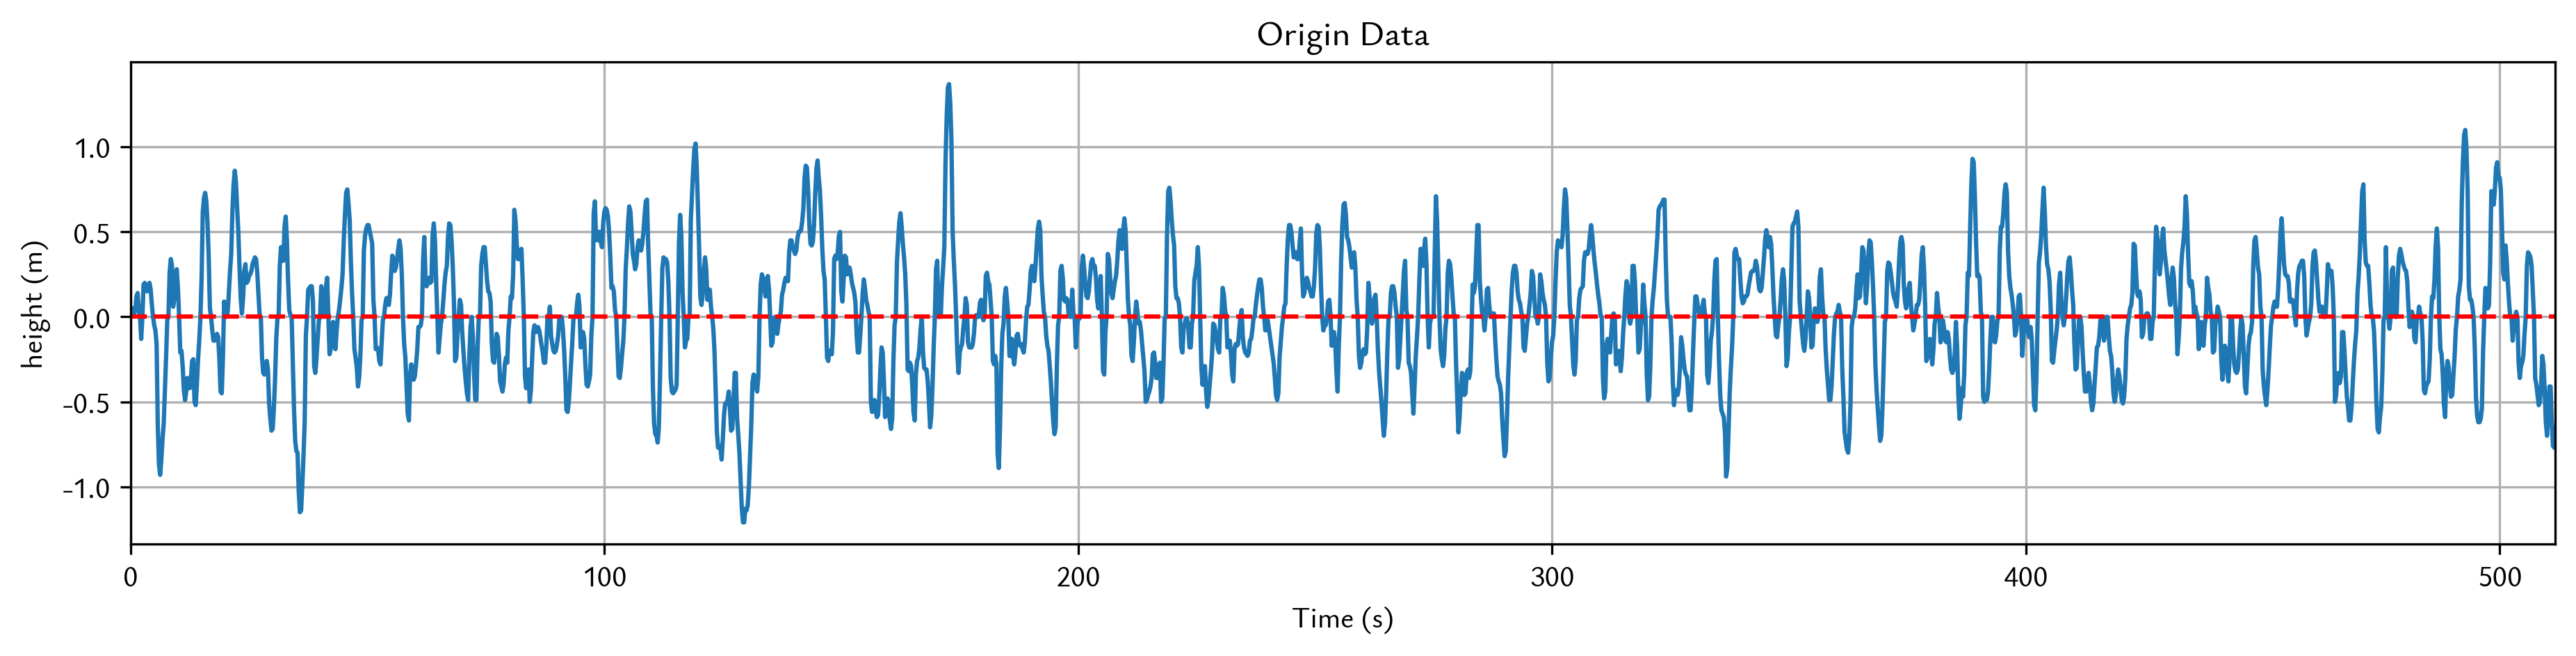

In [25]:


def readt(t):
    return float(t.split('\n')[0])
with open('data.txt','r') as f:
    data=np.array(list(map(readt,f.readlines())))
    f.close();del f
    
time=np.arange(0,data.shape[0]/4,0.25)
plt.figure(figsize=(15,3),dpi=300)
plt.title('Origin Data')
plt.plot(time,data)
plt.xlim(time[0],time[-1])
plt.xlabel('Time (s)');plt.ylabel('height (m)')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.show()

ADF检验的p值为： 4.0553241971218505e-29
去掉趋势项后的ADF检验的p值为： 4.994558241988211e-29


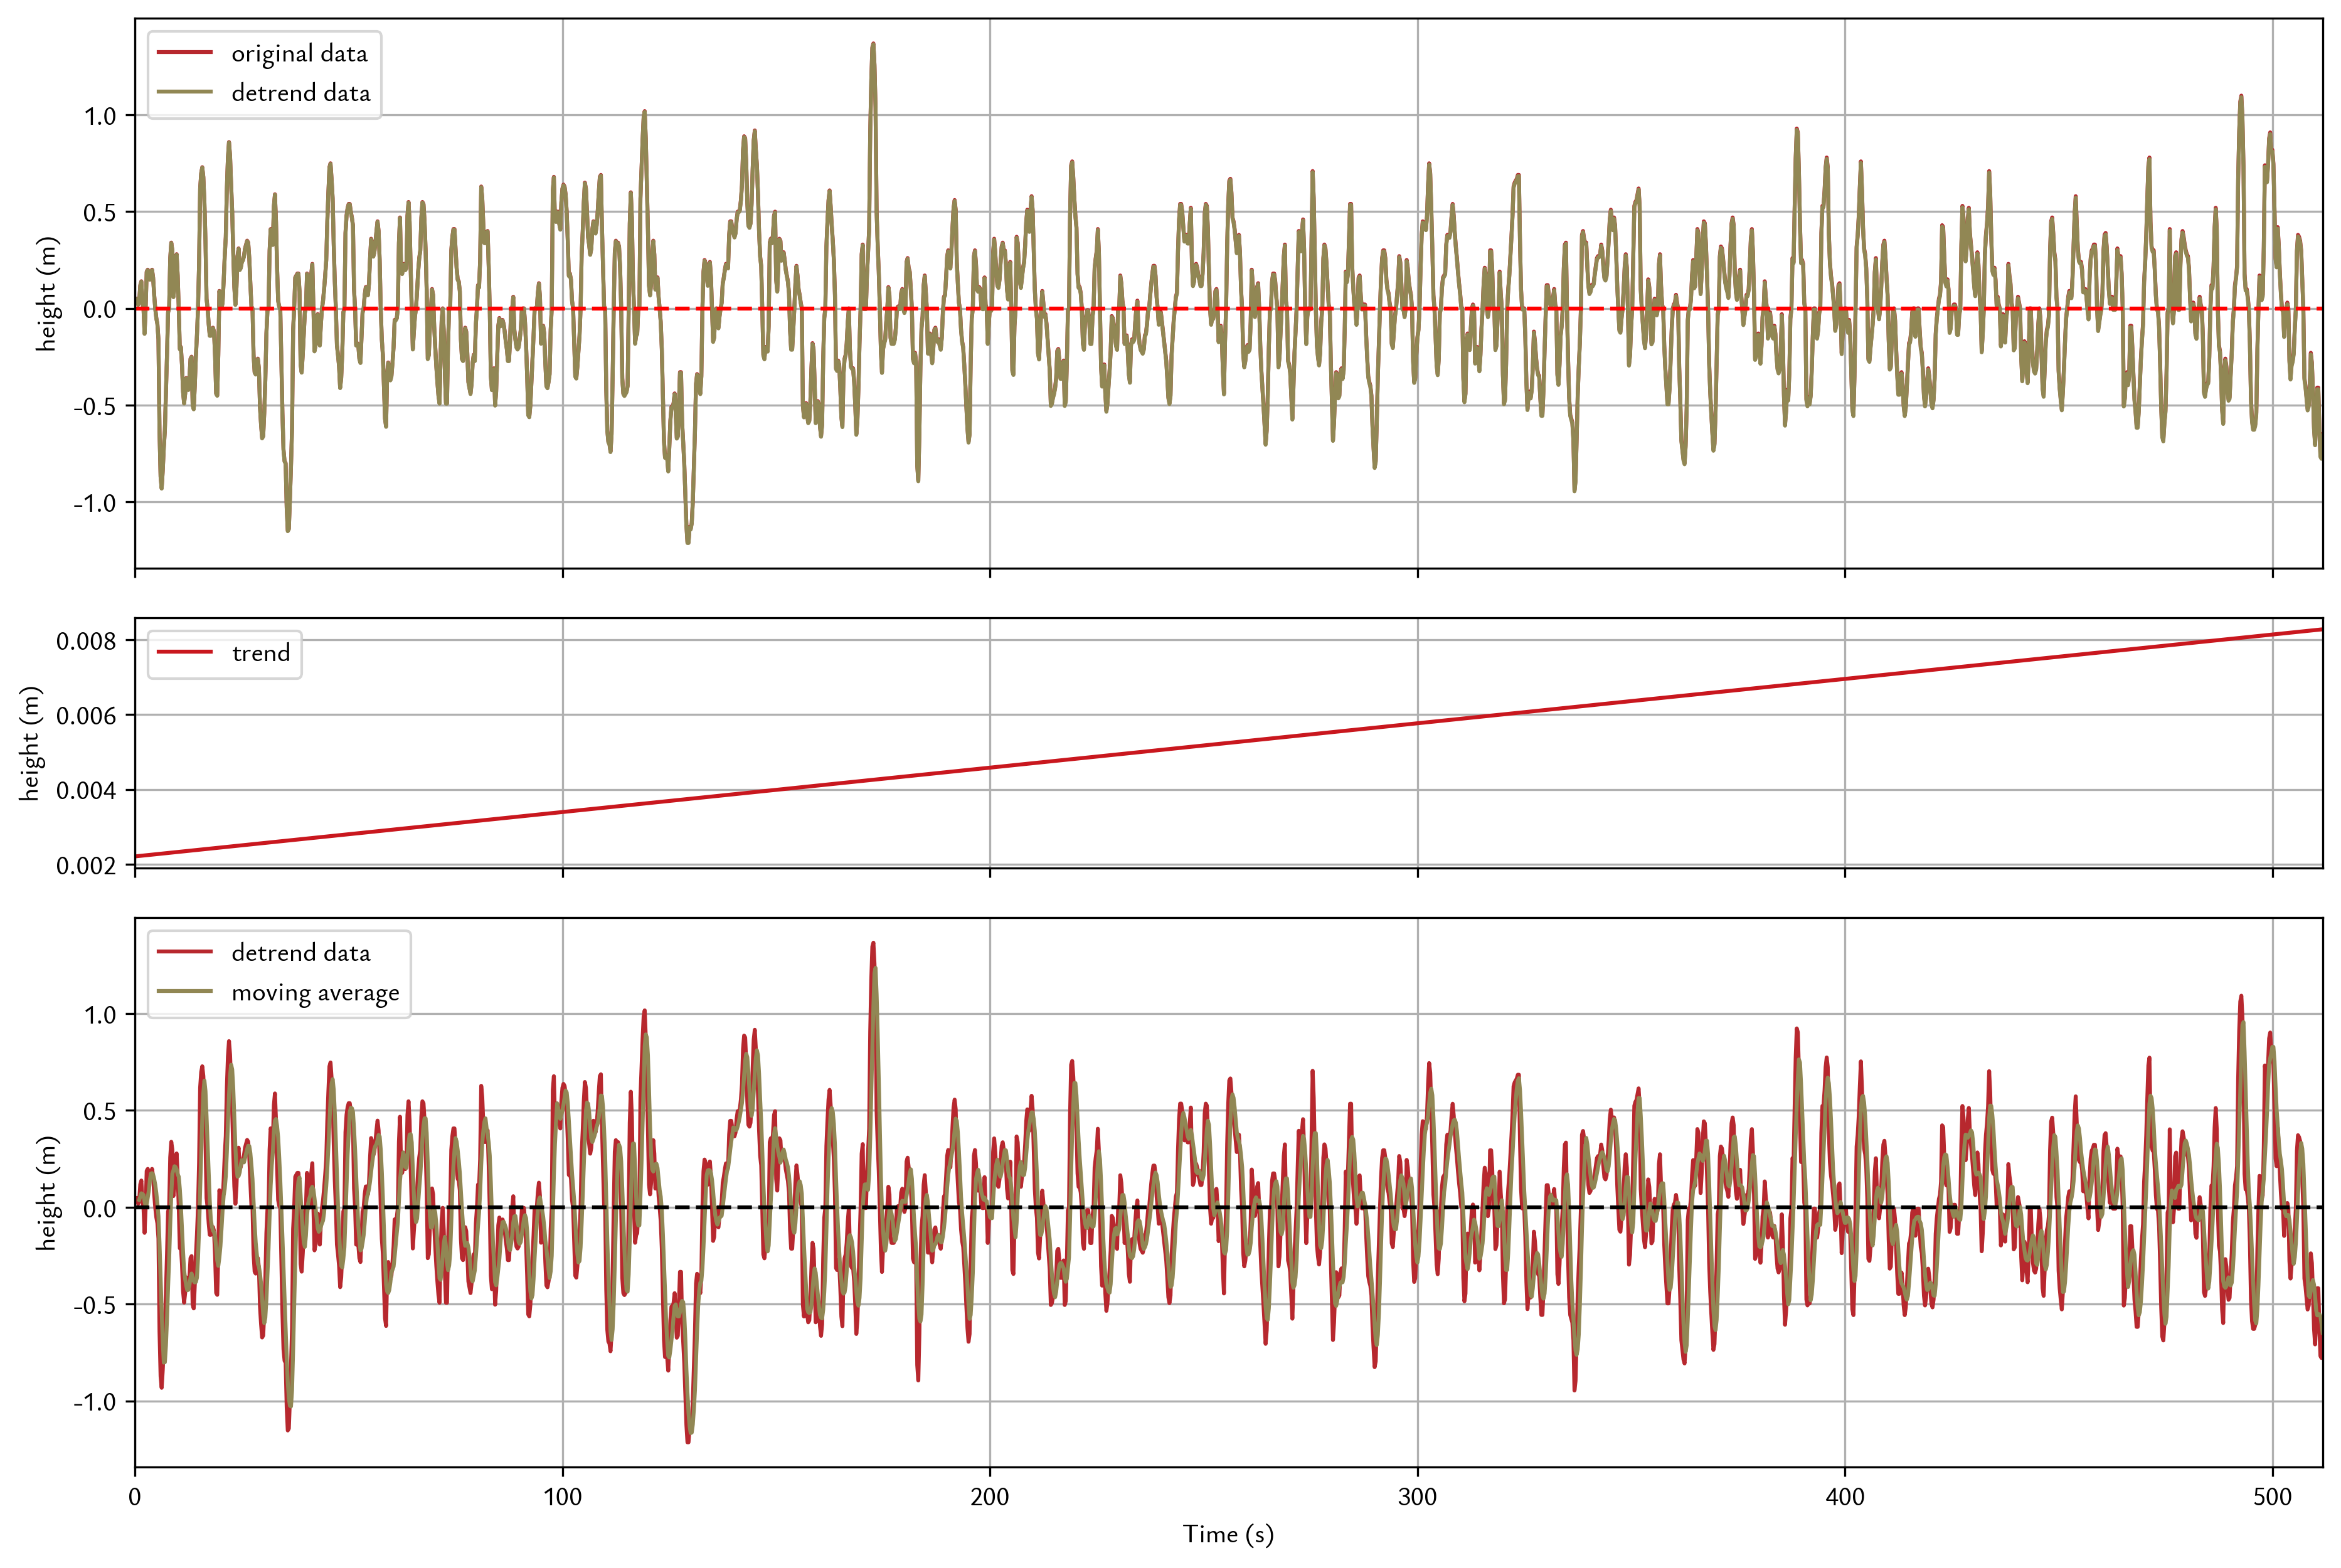

In [26]:
# 对数据进行差分并进行平稳性检验
diff_data = np.diff(data)
adftest = adfuller(diff_data)
print('ADF检验的p值为：', adftest[1])#如果p值小于0.05，则拒绝原假设，即序列平稳

# 拟合一次线性趋势，得到趋势项
X = time
Y = data
coefficients = np.polyfit(X, Y, 1)
trend = X * coefficients[0] + coefficients[1]
detrend=data-trend

# 对数据进行差分并进行平稳性检验
diff_data_without_trend = diff_data - X[:-1] * coefficients[0]
adftest = adfuller(diff_data_without_trend)
print('去掉趋势项后的ADF检验的p值为：', adftest[1])#如果p值小于0.05，则拒绝原假设，即序列平稳

# 合并为Pandas DataFrame并计算均线
df=pd.DataFrame(index=time,columns=['or'],data=data)
df['detrend']=detrend
df['ma'] = df['detrend'].rolling(window=5).mean()

# 可视化
plt.figure(figsize=(15,10),dpi=300)
plt.subplot(5,1,(1,2))
plt.plot(time,df['or'], label='original data',c='#b7282e')
plt.plot(time,df['detrend'], label='detrend data',c='#918754')
plt.legend()
plt.axhline(y=0, color='r', linestyle='--')
plt.xlim(time[0],time[-1])
plt.xticks(np.arange(0,501,100),[])
plt.ylabel('height (m)')
plt.grid()
plt.subplot(5,1,3)
plt.plot(time,trend, label='trend',c='#c9171e')
plt.legend()
plt.xlim(time[0],time[-1]);plt.xticks(np.arange(0,501,100),[])
plt.ylabel('height (m)')
plt.grid()
plt.subplot(5,1,(4,5))
plt.plot(time,df['detrend'], label='detrend data',c='#b7282e')
plt.plot(time,df['ma'], label='moving average',c='#918754')
plt.legend()
plt.xlim(time[0],time[-1])
plt.xlabel('Time (s)');plt.ylabel('height (m)')
plt.axhline(y=0, color='k', linestyle='--')
plt.grid()
plt.show()

del X,Y,diff_data,diff_data_without_trend,coefficients,adftest,trend

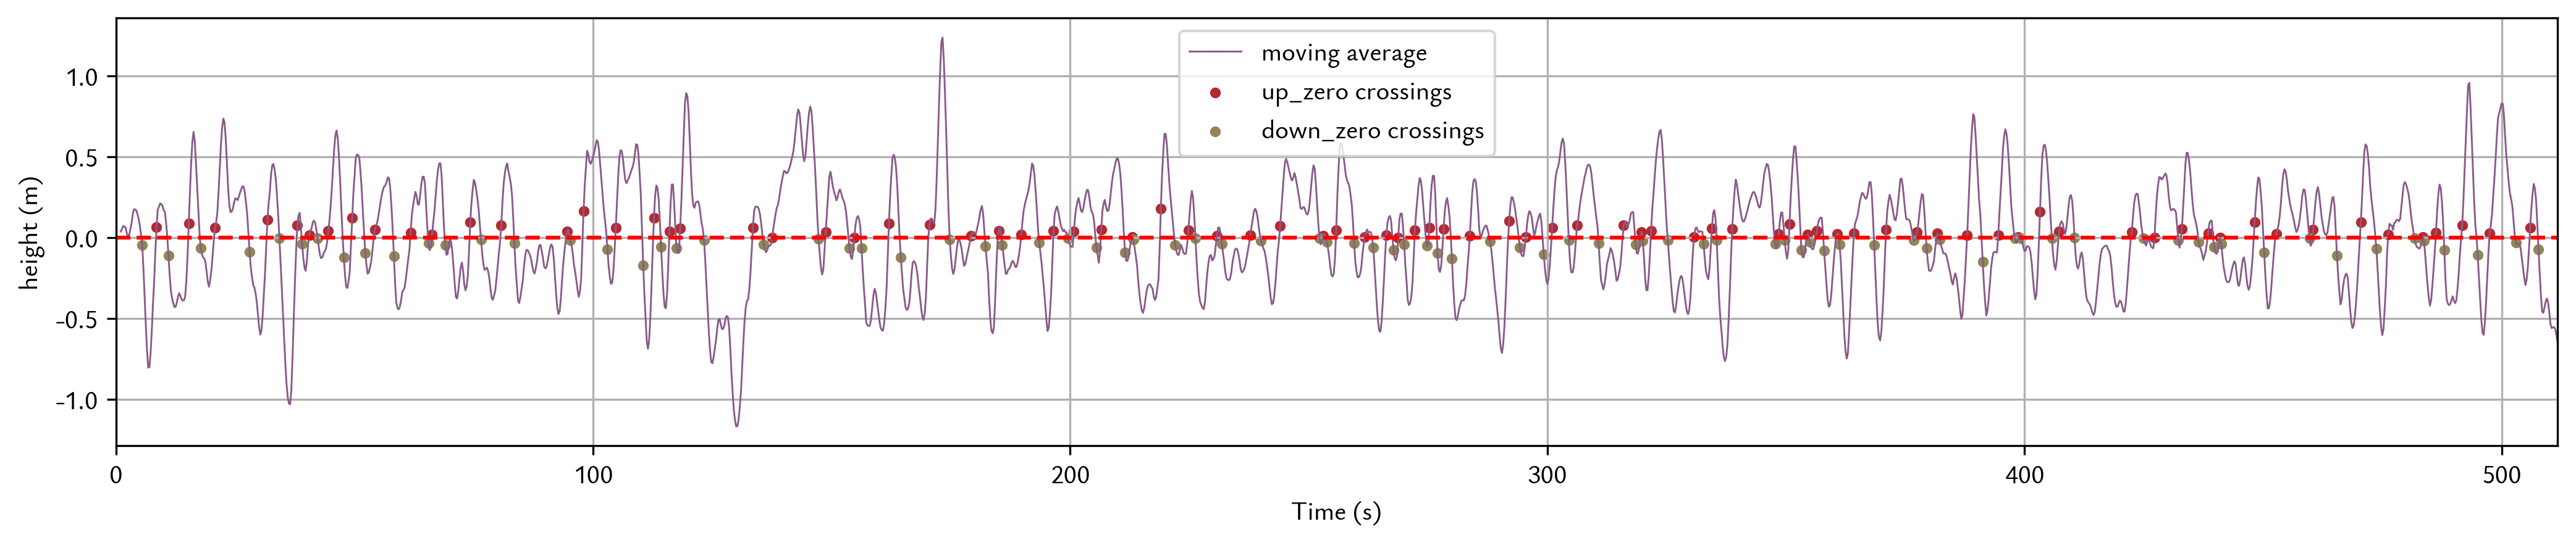

In [27]:
up_zero_crossings = np.where(np.diff(np.sign(df['ma'])) > 0)[0]+1
dow_zero_crossings = np.where(np.diff(np.sign(df['ma'])) < 0)[0]+1

plt.figure(figsize=(17,3),dpi=300)
plt.plot(time,df['ma'], label='moving average',c='#895b8a',linewidth=0.7)
plt.scatter(time[up_zero_crossings],df['ma'][time[up_zero_crossings]],c='#b7282e',label='up_zero crossings',s=10)
plt.scatter(time[dow_zero_crossings],df['ma'][time[dow_zero_crossings]],c='#918754',label='down_zero crossings',s=10)
plt.legend()
plt.xlim(time[0],time[-1])
plt.xlabel('Time (s)');plt.ylabel('height (m)')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid()
plt.show()

上跨零点法 1/10大波平均波高(显著波高)：1.447m 对应周期为：12.000s
上跨零点法 1/3 大波平均波高(有效波高)：1.079m 对应周期为：8.857s


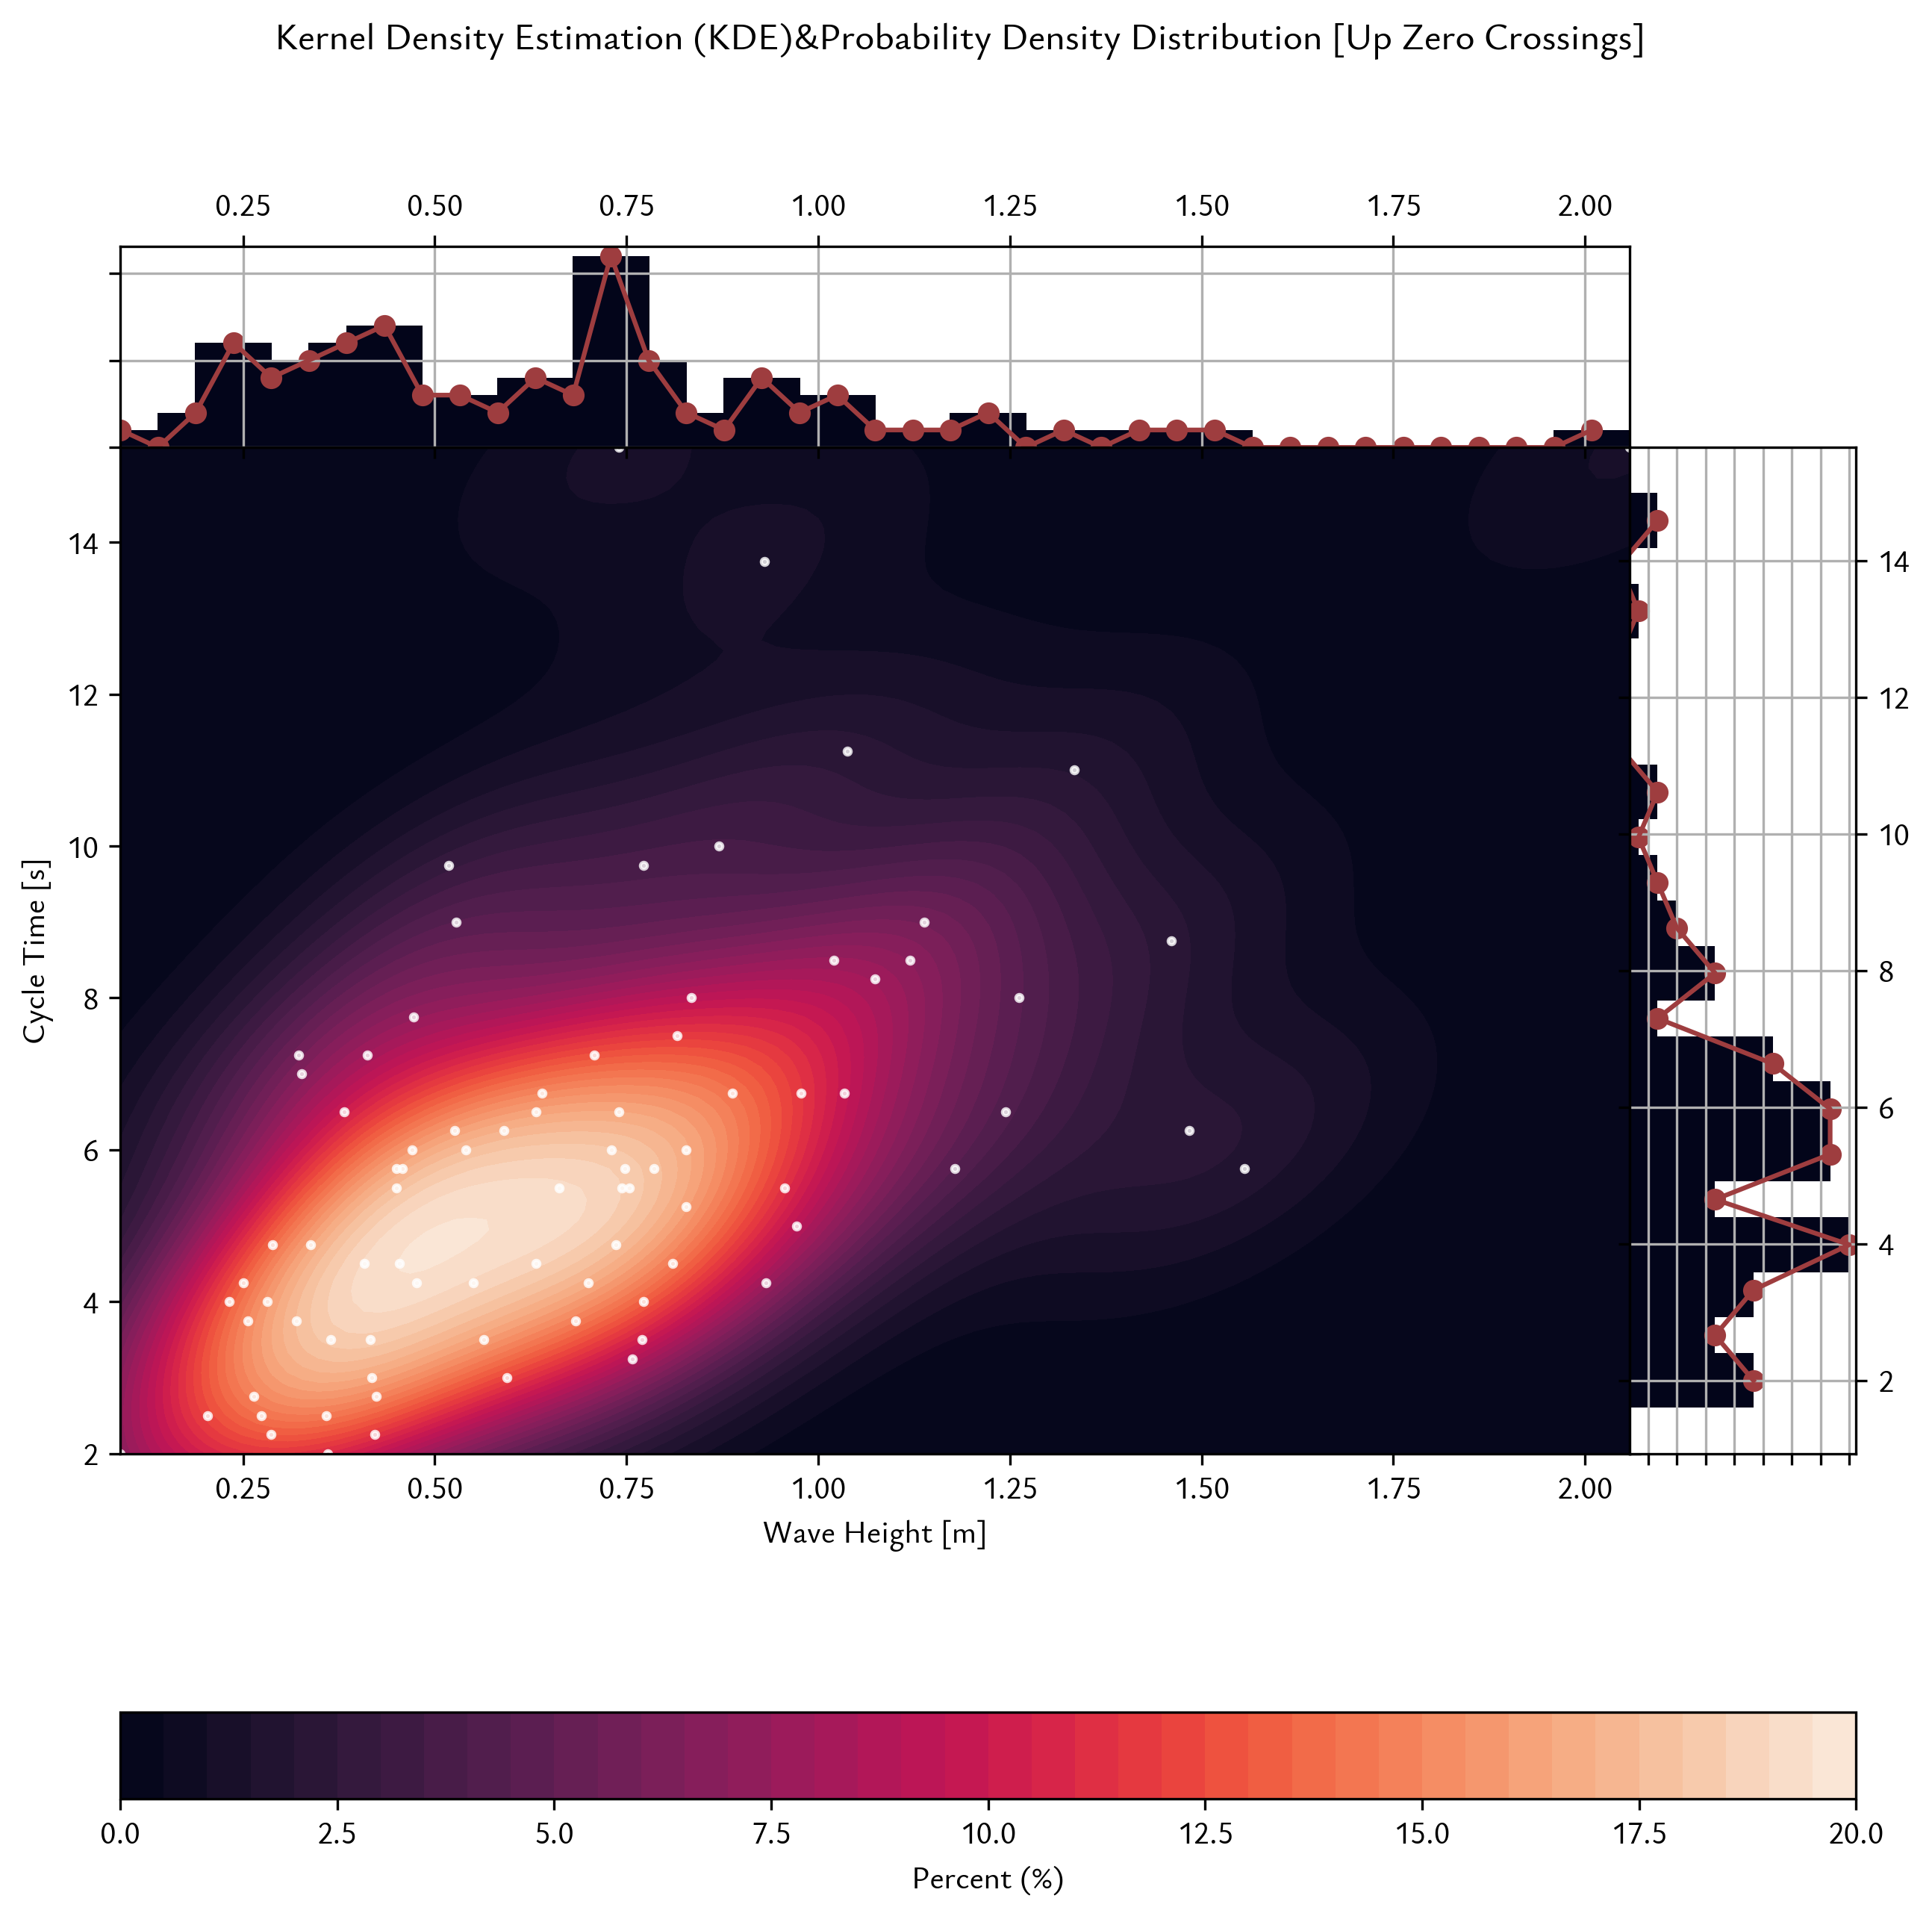

In [34]:

def cal_H(arr, indices):
    dists = [arr[indices[i]:indices[i+1]] for i in range(len(indices)-1)]
    return np.array([np.max(dist) - np.min(dist) for dist in dists])
def cal_T(arr, indices):
    dists = [arr[indices[i+1]]-arr[indices[i]] for i in range(len(indices)-1)]
    return np.array(dists)
def sort(A, B):
    sorted_indices = np.argsort(A)[::-1]
    sorted_A = A[sorted_indices]
    sorted_B = B[sorted_indices]
    return sorted_A, sorted_B
def average_of_top_percent(arr, percent):
    if not 0 < percent < 1:
        raise ValueError("Input percent must be between 0 and 1 exclusive.")
    arr = sorted(arr)
    top_num = int(percent * len(arr))
    top_arr = arr[-top_num:]
    return sum(top_arr) / top_num if top_num > 0 else 0
H=cal_H(np.array(df['ma']),up_zero_crossings)
T=cal_T(time,up_zero_crossings)
H_sort,T_sort = sort(H,T)
print(f'上跨零点法 1/10大波平均波高(显著波高)：{average_of_top_percent(H_sort,0.1):.3f}m',end='')
print(f' 对应周期为：{average_of_top_percent(T_sort,0.1):.3f}s')
print(f'上跨零点法 1/3 大波平均波高(有效波高)：{average_of_top_percent(H_sort,1/3):.3f}m',end='')
print(f' 对应周期为：{average_of_top_percent(T_sort,1/3):.3f}s')
x, y = sort(H,T)
bi,hi,tmp=plt.hist(T_sort,bins=20,orientation='horizontal')
bi2,hi2,tmp=plt.hist(H_sort,bins=40,orientation='horizontal')
plt.close()

# 创建散点图
plt.figure(figsize=[10,10],dpi=300)
plt.suptitle('Kernel Density Estimation (KDE)&Probability Density Distribution [Up Zero Crossings]')
ax=plt.gca()
# 创建&绘制 KDE 曲线
kde = gaussian_kde(np.vstack([H_sort,T_sort]))
Hi, Ti = np.mgrid[H_sort.min():H_sort.max():100j, T_sort.min():T_sort.max():100j]
zi = kde(np.vstack([Hi.flatten(), Ti.flatten()]))
c=ax.contourf(Hi, Ti, zi.reshape(Hi.shape)*100,40,cmap='rocket')
plt.ylabel('Cycle Time [s]')
plt.xlabel('Wave Height [m]')
ax.scatter(x, y, s=5, color='white', alpha=0.8)
tik_x=ax.get_xticks()
xlim=ax.get_xlim()
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size="20%", pad=0, sharex=ax)
ax2.bar(hi2[:-1],bi2,width=0.1,color="#03051A")
ax2.plot(hi2[:-1],bi2,c='#9e3d3f')
ax2.scatter(hi2[:-1],bi2,c='#9e3d3f')
ax2.grid(True)
ax3 = divider.append_axes("right", size="15%", pad=0, sharex=ax)
ax3.barh(hi[:-1],bi/6,color="#03051A")
ax3.plot(bi/6,hi[:-1],c='#9e3d3f')
ax3.scatter(bi/6,hi[:-1],c='#9e3d3f')
ax3.grid(True)
#ax3.set_xlim(0,20)
ax.set_xlim(xlim)
ax2.tick_params(top=True,bottom=True,labeltop=True,labelbottom=False,labelleft=False)
ax3.tick_params(right=True,left=True,labelright=True,labelleft=False,labelbottom=False)
ax.tick_params(right=True,left=True,top=True,bottom=True)
plt.colorbar(c,orientation='horizontal',label='Percent (%)')
plt.show()

下跨零点法 1/10大波平均波高(显著波高)：1.339m 对应周期为：11.906s
下跨零点法 1/3 大波平均波高(有效波高)：1.097m 对应周期为：9.152s


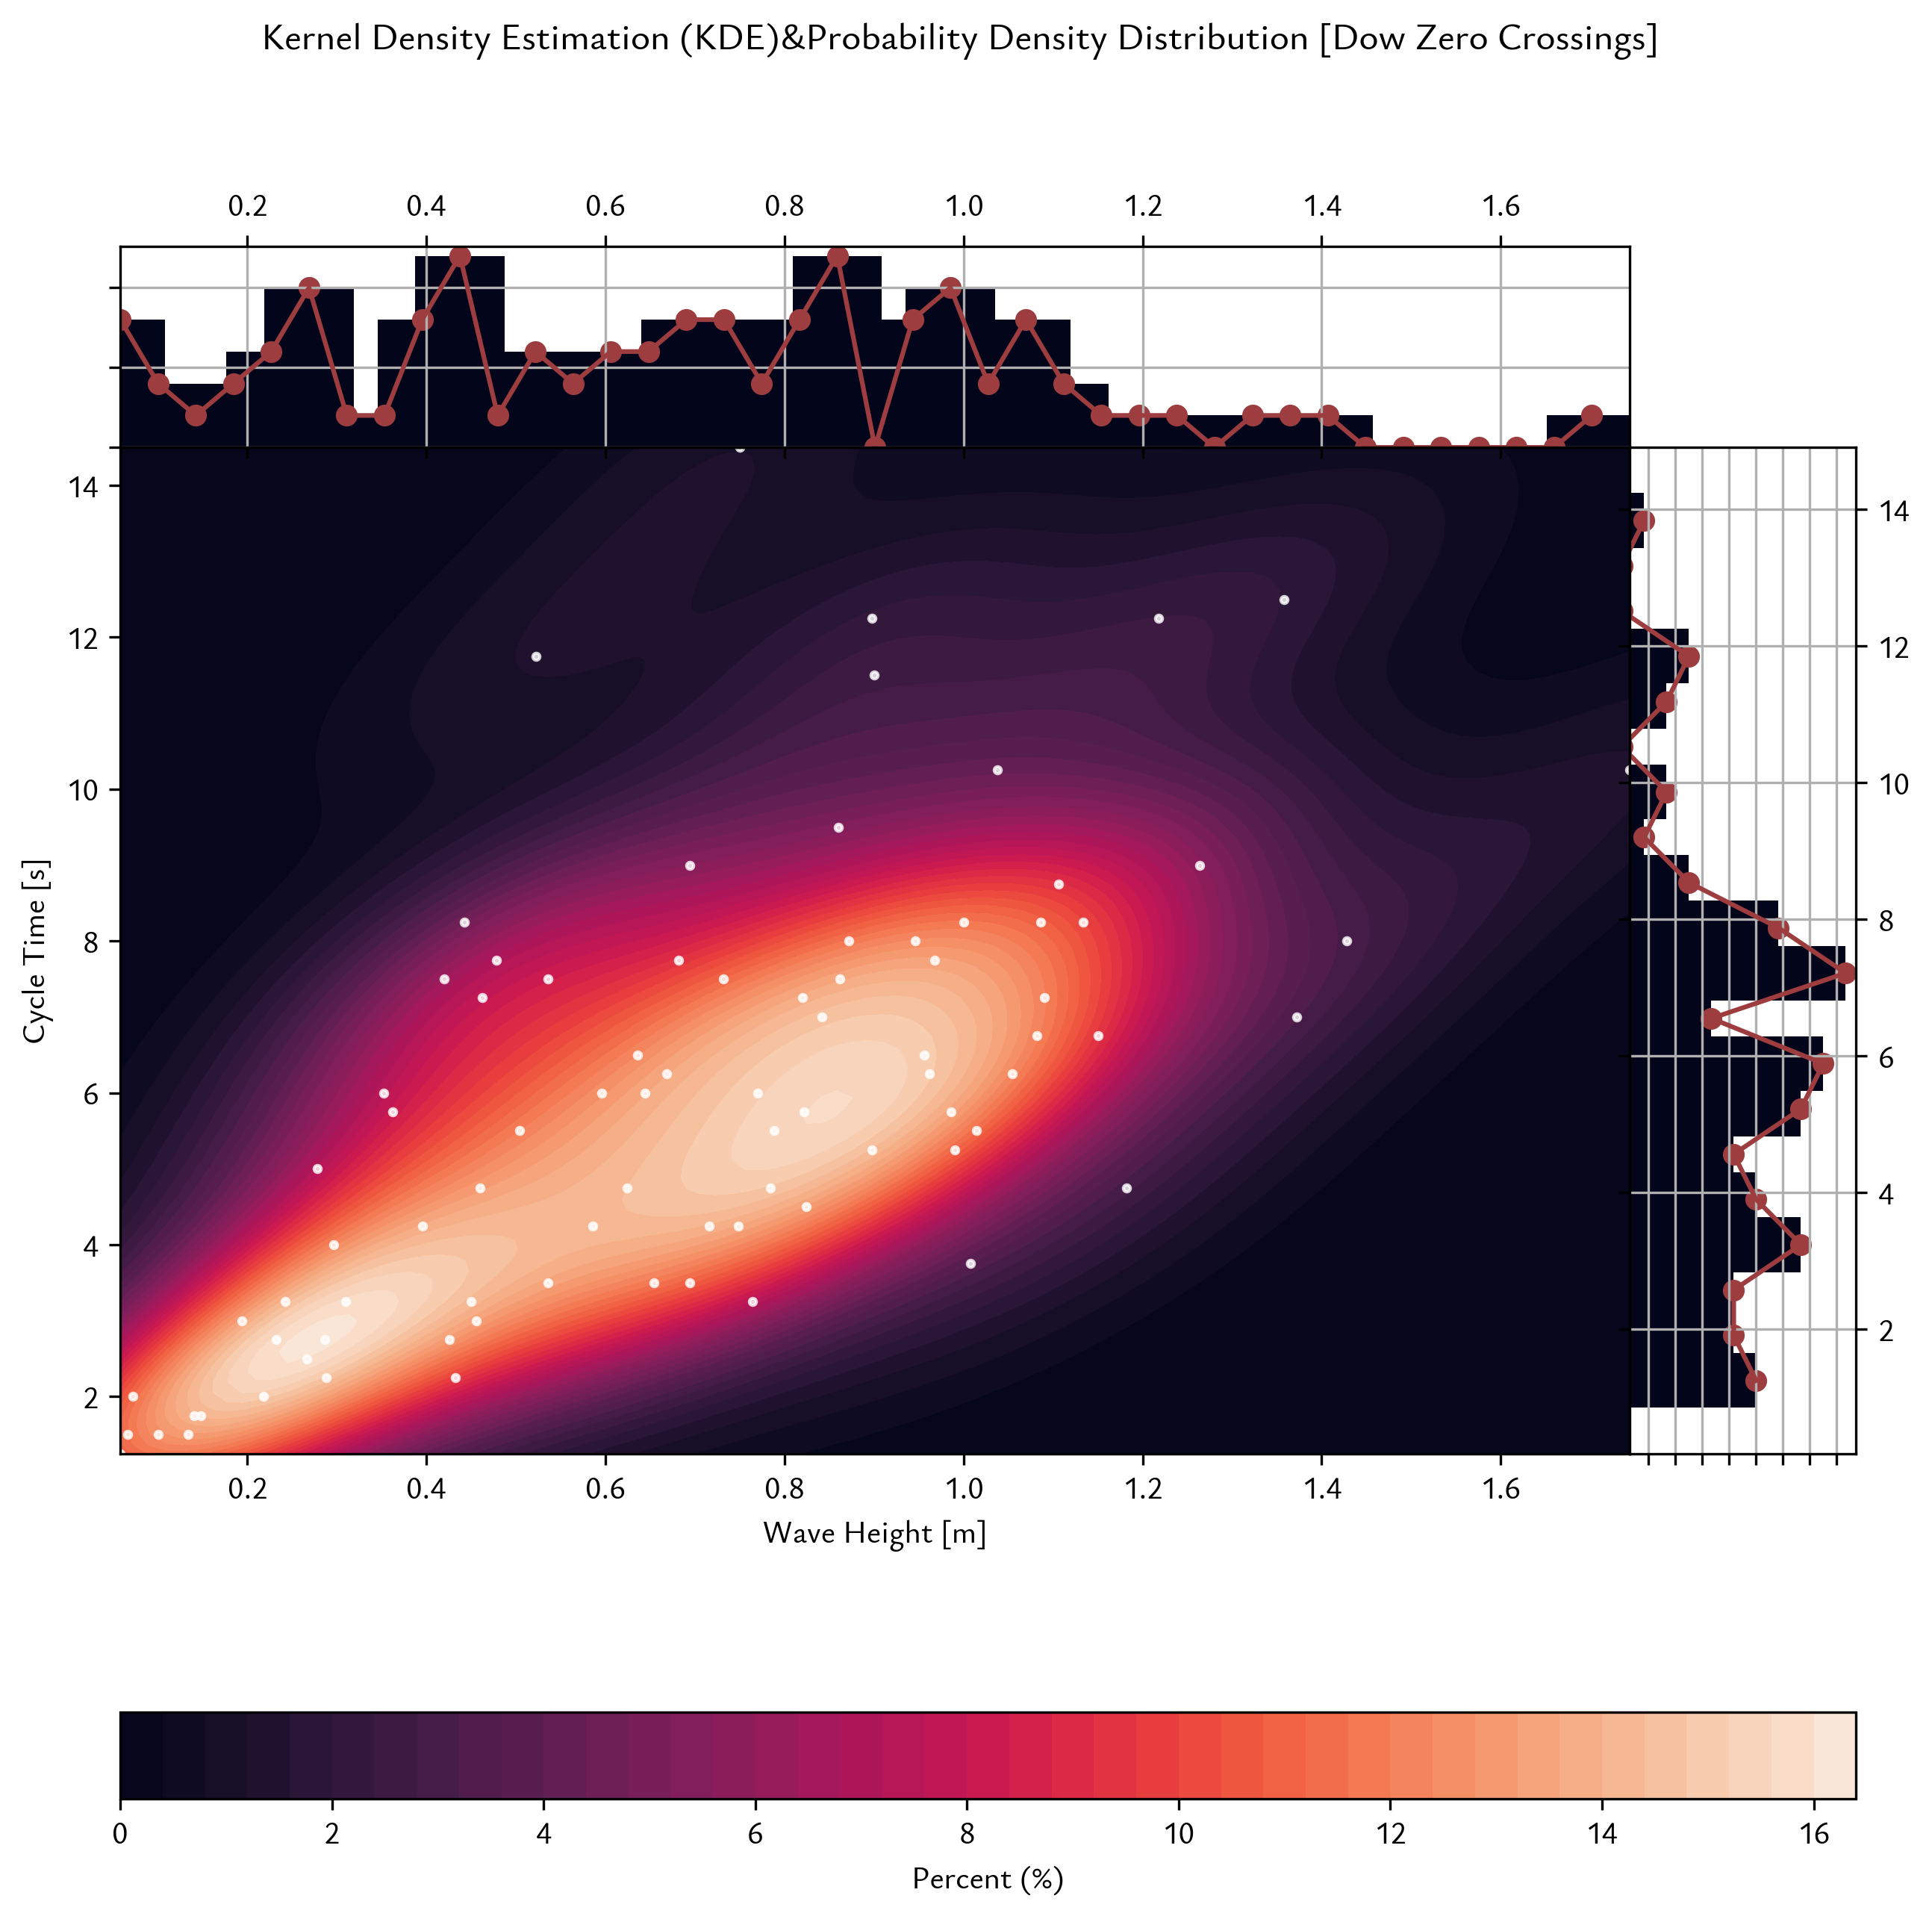

In [35]:
H=cal_H(np.array(df['ma']),dow_zero_crossings)
T=cal_T(time,dow_zero_crossings)
H_sort,T_sort = sort(H,T)
print(f'下跨零点法 1/10大波平均波高(显著波高)：{average_of_top_percent(H_sort,0.1):.3f}m',end='')
print(f' 对应周期为：{average_of_top_percent(T_sort,0.1):.3f}s')
print(f'下跨零点法 1/3 大波平均波高(有效波高)：{average_of_top_percent(H_sort,1/3):.3f}m',end='')
print(f' 对应周期为：{average_of_top_percent(T_sort,1/3):.3f}s')
x, y = sort(H,T)
bi,hi,tmp=plt.hist(T_sort,bins=20,orientation='horizontal')
bi2,hi2,tmp=plt.hist(H_sort,bins=40,orientation='horizontal')
plt.close()

# 创建散点图
plt.figure(figsize=[10,10],dpi=300)
plt.suptitle('Kernel Density Estimation (KDE)&Probability Density Distribution [Dow Zero Crossings]')
ax=plt.gca()
# 创建&绘制 KDE 曲线
kde = gaussian_kde(np.vstack([H_sort,T_sort]))
Hi, Ti = np.mgrid[H_sort.min():H_sort.max():100j, T_sort.min():T_sort.max():100j]
zi = kde(np.vstack([Hi.flatten(), Ti.flatten()]))
c=ax.contourf(Hi, Ti, zi.reshape(Hi.shape)*100,40,cmap='rocket')
plt.ylabel('Cycle Time [s]')
plt.xlabel('Wave Height [m]')
ax.scatter(x, y, s=5, color='white', alpha=0.8)
tik_x=ax.get_xticks()
xlim=ax.get_xlim()
divider = make_axes_locatable(ax)
ax2 = divider.append_axes("top", size="20%", pad=0, sharex=ax)
ax2.bar(hi2[:-1],bi2,width=0.1,color="#03051A")
ax2.plot(hi2[:-1],bi2,c='#9e3d3f')
ax2.scatter(hi2[:-1],bi2,c='#9e3d3f')
ax2.grid(True)
ax3 = divider.append_axes("right", size="15%", pad=0, sharex=ax)
ax3.barh(hi[:-1],bi/6,color="#03051A")
ax3.plot(bi/6,hi[:-1],c='#9e3d3f')
ax3.scatter(bi/6,hi[:-1],c='#9e3d3f')
ax3.grid(True)
#ax3.set_xlim(0,20)
ax.set_xlim(xlim)
ax2.tick_params(top=True,bottom=True,labeltop=True,labelbottom=False,labelleft=False)
ax3.tick_params(right=True,left=True,labelright=True,labelleft=False,labelbottom=False)
ax.tick_params(right=True,left=True,top=True,bottom=True)
plt.colorbar(c,orientation='horizontal',label='Percent (%)')
plt.show()

In [ ]:
3.10.10 | packaged by Anaconda, Inc. | (main, Mar 21 2023, 18:39:17) [MSC v.1916 64 bit (AMD64)]
numpy                          1.24.3
pandas                         1.5.3
matplotlib                     3.7.1
matplotlib-inline              0.1.6
scipy                          1.10.1
statsmodels                    0.13.5
seaborn                        0.12.2
